In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.distributions.normal import Normal
import torch.optim as optim
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.nn import Parameter
from torch import nn
from torch.utils.data import Dataset, DataLoader

import scipy.stats
import time
import pickle
import os
import sys

In [2]:
!rm -r h-vae/

In [3]:
!git clone https://github.com/Daniil-Selikhanovych/h-vae

Cloning into 'h-vae'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 106 (delta 32), reused 97 (delta 26), pack-reused 0
Receiving objects: 100% (106/106), 400.62 KiB | 16.02 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [4]:
!pip install pyro-ppl

from pyro.nn import AutoRegressiveNN

     |████████████████████████████████| 614kB 6.3MB/s 


In [5]:
path_to_gaussians = os.path.join(os.getcwd(), 'h-vae', 'gaussians')
path_to_gaussians_api = os.path.join(path_to_gaussians, 'api')

sys.path.append(path_to_gaussians)
sys.path.append(path_to_gaussians_api)

In [6]:
from models import HVAE, NF, VB, IAF

In [7]:
class gaussian_dataset(Dataset):
    def __init__(self, x):
          'Initialization'
          self.x = x

    def __len__(self):
          'Denotes the total number of samples'
          return self.x.shape[0]

    def __getitem__(self, index):
          'Generates one sample of data'
          x_index = self.x[index]

          return x_index

In [ ]:
def run_test(d, params, 
             batch_size=256,
             clip_value=None,
             dtype=torch.float32, 
             device=torch.device("cpu")):
    """ 
    Run the gaussian test with dimension d 
    """

    ######### Problem Specification

    # Data generation parameters
    prior_mu_z = torch.zeros(d, dtype=dtype)    # Prior mean
    prior_sigma_z = torch.eye(d, dtype=dtype)   # Prior covariance matrix

    # True model parameters
    num_range = torch.arange(-(d-1)/2, (d+1)/2, dtype=dtype)

    t_delta =  num_range / 5 

    print(f"true delta = {t_delta.numpy()}")

    if d == 1:
        t_sigma = torch.ones(1, dtype=dtype)
    else: 
        # Allow sigma to range from 0.1 to 1
        t_sigma = 36/(10*(d-1)**2) * num_range**2 + 0.1 
    print(f"true sigma = {t_sigma.numpy()}")

    ######### Variable Initialization

    # Initial model parameters - same across all methods
    init_delta = prior_mu_z.clone().to(device)
    init_log_sigma = 3 * torch.ones(d).to(device)

    # Initial HVAE variational parameters
    init_T = torch.tensor(5., dtype=dtype, device=device)
    init_eps = 0.005 * torch.ones(d, dtype=dtype)
    max_eps = params['max_eps'] * torch.ones(d, dtype=dtype)
    init_logit_eps = torch.log(init_eps/(max_eps - init_eps)).to(device)
    init_log_T_0 = torch.log(init_T - 1)

    # Initial NF variational parameters
    init_u_pre_reparam = torch.tensor(scipy.stats.truncnorm.rvs(-2, 2, 
                                                                scale=0.1, 
                                                                size=d),
                                      dtype=dtype, device=device)
    init_w = torch.tensor(scipy.stats.truncnorm.rvs(-2, 2, scale=0.1, size=d),
                          dtype=dtype, device=device)
    init_b = torch.tensor(0.1, dtype=dtype, device=device)

    # Initial VAE parameters
    init_mu_z = prior_mu_z.clone()
    init_log_sigma_z = torch.ones(d, dtype=dtype)

    ######### Set up models
    init_params = [[init_delta, init_log_sigma, init_logit_eps, init_log_T_0],
                   [init_delta, init_log_sigma, init_logit_eps, init_log_T_0],
                   [init_delta, init_log_sigma, init_u_pre_reparam, init_w, init_b],
                   [init_delta, init_log_sigma, init_u_pre_reparam, init_w, init_b],
                   [init_delta, init_log_sigma, init_mu_z, init_log_sigma_z]]

    HVAE_model_1 = HVAE(params,
        ['delta', 'log_sigma', 'logit_eps', 'log_T_0'],
        init_params[0], 
        'HVAE_1', d, params['HVAE_K_1'])
    HVAE_model_2 = HVAE(params,
        ['delta', 'log_sigma', 'logit_eps', 'log_T_0'],
        init_params[1], 
        'HVAE_2', d, params['HVAE_K_2'])
    
    
    NF_model_1 = NF(params,
        ['delta', 'log_sigma', 'u_pre_reparam', 'w', 'b'],
        init_params[2],
        'NF_1', d, params['NF_K_1'])
    
    NF_model_2 = NF(params,
        ['delta', 'log_sigma', 'u_pre_reparam', 'w', 'b'],
        init_params[3],
        'NF_2', d, params['NF_K_2'])
    
    VB_model = VB(params,
        ['delta', 'log_sigma', 'mu_z', 'log_sigma_z'], 
        init_params[4], 'VB', d)

    #model_list = [HVAE_model_1, HVAE_model_2, NF_model_1]
    #model_list = [HVAE_model_1, NF_model_1]
    model_list = [HVAE_model_1, HVAE_model_2, NF_model_1, NF_model_2, VB_model]

    print("Models were initialized!")
    
    ######### Generate Training Data & Save - One for each test

    train_data_list = []

    for i in range(params['n_tests']):
        z = MultivariateNormal(prior_mu_z, prior_sigma_z).sample()
        x = MultivariateNormal(z + t_delta, 
                               torch.diag(t_sigma**2)).sample([params['n_data']])
        x = x.to(device)
        train_data_list.append(x)

    # Folder should have already been created in the initializations
    data_path = os.path.join('save', str(d), 'train_data.p')
    pickle.dump(train_data_list, open(data_path, 'wb')) 

    # Store the final parameter values for all test runs in this dictionary
    final_params = {}

    for i in range(len(model_list)):
        final_values = []
        m = model_list[i]
        model_init_params = init_params[i]

        for j in range(params['n_tests']):
            print("------------------------------------------------------")
            print(f"Test = {j}")
            print("------------------------------------------------------")
            m._reinitialize(model_init_params)
            gaussian_data = gaussian_dataset(train_data_list[j])
            train_dataloader = DataLoader(gaussian_data, batch_size=batch_size,
                                          shuffle=False, num_workers=0)
            (delta, sigma) = m.train(train_dataloader, j, 
                                     t_delta, t_sigma,
                                     clip_value)
            final_values.append((delta, sigma))

        final_params[m.model_name] = final_values.copy()

    ######### Test models using difference between parameters

    param_diffs = {}

    for m in model_list:
        
        diffs = []

        for i in range(params['n_tests']):
            delta = final_params[m.model_name][i][0]
            sigma = final_params[m.model_name][i][1]

            delta_diff = np.sum((delta - t_delta.numpy())**2)
            sigma_diff = np.sum((sigma - t_sigma.numpy())**2)
            theta_diff = delta_diff + sigma_diff
            print(f"Model {m.model_name}, test = {i}, result delta diff = {delta_diff}")
            print(f"Model {m.model_name}, test = {i}, result sigma diff = {sigma_diff}")
            print(f"Model {m.model_name}, test = {i}, result theta diff = {theta_diff}")

            diffs.append((delta_diff, sigma_diff, theta_diff))

        param_diffs[m.model_name] = diffs.copy()

    # Save parameter differences in a pickle file
    diff_path = os.path.join('save', str(d), 'all_diffs.p')
    pickle.dump(param_diffs, open(diff_path, 'wb'))

In [ ]:
params = {

    # PROBLEM SPECIFICATION
    #'dims': [1, 2, 3, 5, 11, 25, 51, 101, 201, 301], # Dimensions to test
    'dims': [50],
    'n_data': 10000,                                 # Number of data points

    # TEST HYPERPARAMETERS
    'n_tests': 3,      # Number of experiments to run

    # GLOBAL OPTIMIZATION PARAMETERS
    'n_iter': 2000,    # Number of optimization iterations
    'n_batch': 10,      # Number of points for ELBO estimate
    'rms_eta': 0.001,   # Stepsize for RMSProp
    'save_every': 20,   # Save parameter information every so often
    'print_every': 20, # Print less often than save

    # HVAE HYPERPARAMETERS
    'HVAE_K_1': 1,    # Number of leapfrog/cooling steps for HVAE flow 1
    'HVAE_K_2': 10,   # Number of leapfrog/cooling steps for HVAE flow 2
    'max_eps': 0.5,   # Maximum leapfrog step size per dimension 

    # NF HYPERPARAMETERS
    'NF_K_1': 1,    # Number of flow steps for NF flow 1
    'NF_K_2': 30,   # Number of flow steps for NF flow 2
    
}

In [ ]:
device = torch.device("cpu")
dtype = torch.float32
clip_value = 1e-4
batch_size = 256

In [ ]:
dims = params['dims']
seed = 12345
np.random.seed(seed)
torch.manual_seed(seed)
for d in dims:
    print('**** Running test for d={0:d} ****'.format(d))
    run_test(d, params, batch_size, clip_value, dtype, device)

Выходные данные были обрезаны до нескольких последних строк (5000).
HVAE_2, d: 50, Iter: 3-420, s/iter: 2.358e-01, ELBO: -2.734e+05
Cur diff delta = 61.082489013671875
Cur diff sigma = 0.07791738957166672
Cur diff theta = 61.16040640324354
---------------------------------------
HVAE_2, d: 50, Iter: 3-440, s/iter: 2.374e-01, ELBO: -2.713e+05
Cur diff delta = 61.27128601074219
Cur diff sigma = 0.07786687463521957
Cur diff theta = 61.34915288537741
---------------------------------------
HVAE_2, d: 50, Iter: 3-460, s/iter: 2.375e-01, ELBO: -2.713e+05
Cur diff delta = 61.323486328125
Cur diff sigma = 0.07777004688978195
Cur diff theta = 61.40125637501478
---------------------------------------
HVAE_2, d: 50, Iter: 3-480, s/iter: 2.357e-01, ELBO: -2.726e+05
Cur diff delta = 60.98843002319336
Cur diff sigma = 0.07740595191717148
Cur diff theta = 61.06583597511053
---------------------------------------
HVAE_2, d: 50, Iter: 3-500, s/iter: 2.370e-01, ELBO: -2.734e+05
Cur diff delta = 61.07826

In [ ]:
model_names = ['HVAE_1', 'HVAE_2', 'NF_1', 'NF_2', 'VB']
diff_delta_results = {}
diff_sigma_results = {}
diff_results = {}
for name in model_names:
    diff_delta_tests = np.zeros(params['n_tests'])
    diff_sigma_tests = np.zeros(params['n_tests'])
    diff_tests = np.zeros(params['n_tests'])
    for i in range(params['n_tests']):
        file_name = name + '_train_' + str(i) + '.p'
        diff_path = os.path.join('save', str(params['dims'][0]), file_name)
        with open(diff_path, 'rb') as f:
            data = pickle.load(f)
            elbo = data['elbo']
            diff_delta = data['diff_delta']
            diff_sigma = data['diff_sigma']
            diff = diff_delta + diff_sigma
            diff_delta_is_not_nan = diff_delta[~np.isnan(diff_delta)]
            diff_sigma_is_not_nan = diff_sigma[~np.isnan(diff_sigma)]
            diff_is_not_nan = diff[~np.isnan(diff)]
            diff_delta_tests[i] = diff_delta_is_not_nan[-1]
            diff_sigma_tests[i] = diff_sigma_is_not_nan[-1]
            diff_tests[i] = diff_is_not_nan[-1]
    diff_delta_results[name] = diff_delta_tests
    diff_sigma_results[name] = diff_sigma_tests
    diff_results[name] = diff_tests
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, diff delta = {diff_delta_tests}")
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, diff sigma = {diff_sigma_tests}")
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, diff = {diff_tests}")

Model = HVAE_1, dimensionality = 50, diff delta = [55.98429871 36.61581421 61.17256927]
Model = HVAE_1, dimensionality = 50, diff sigma = [0.08275902 0.08233412 0.08402632]
Model = HVAE_1, dimensionality = 50, diff = [56.06705856 36.69814682 61.25659561]
Model = HVAE_2, dimensionality = 50, diff delta = [55.93164825 36.4540596  60.95105743]
Model = HVAE_2, dimensionality = 50, diff sigma = [0.07724414 0.07685412 0.07774906]
Model = HVAE_2, dimensionality = 50, diff = [56.00889206 36.53091431 61.02880478]
Model = NF_1, dimensionality = 50, diff delta = [56.17663574 36.36941528 61.04982758]
Model = NF_1, dimensionality = 50, diff sigma = [30.71139526 30.7229557  30.49786758]
Model = NF_1, dimensionality = 50, diff = [86.88803101 67.09236908 91.54769897]
Model = NF_2, dimensionality = 50, diff delta = [55.8799057  36.48616791 61.18468475]
Model = NF_2, dimensionality = 50, diff sigma = [30.54934692 30.82439995 30.84345245]
Model = NF_2, dimensionality = 50, diff = [86.42925262 67.31056976

In [ ]:
for name in model_names:
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, mean diff delta = {diff_delta_results[name].mean()}")
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, mean diff sigma = {diff_sigma_results[name].mean()}")
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, mean diff = {diff_results[name].mean()}")

Model = HVAE_1, dimensionality = 50, mean diff delta = 51.25756072998047
Model = HVAE_1, dimensionality = 50, mean diff sigma = 0.08303982019424438
Model = HVAE_1, dimensionality = 50, mean diff = 51.34060033162435
Model = HVAE_2, dimensionality = 50, mean diff delta = 51.11225509643555
Model = HVAE_2, dimensionality = 50, mean diff sigma = 0.0772824411590894
Model = HVAE_2, dimensionality = 50, mean diff = 51.189537048339844
Model = NF_1, dimensionality = 50, mean diff delta = 51.19862620035807
Model = NF_1, dimensionality = 50, mean diff sigma = 30.644072850545246
Model = NF_1, dimensionality = 50, mean diff = 81.8426996866862
Model = NF_2, dimensionality = 50, mean diff delta = 51.18358612060547
Model = NF_2, dimensionality = 50, mean diff sigma = 30.73906644185384
Model = NF_2, dimensionality = 50, mean diff = 81.92265319824219
Model = VB, dimensionality = 50, mean diff delta = 43.769035975138344
Model = VB, dimensionality = 50, mean diff sigma = 0.0007537804970828196
Model = VB, d

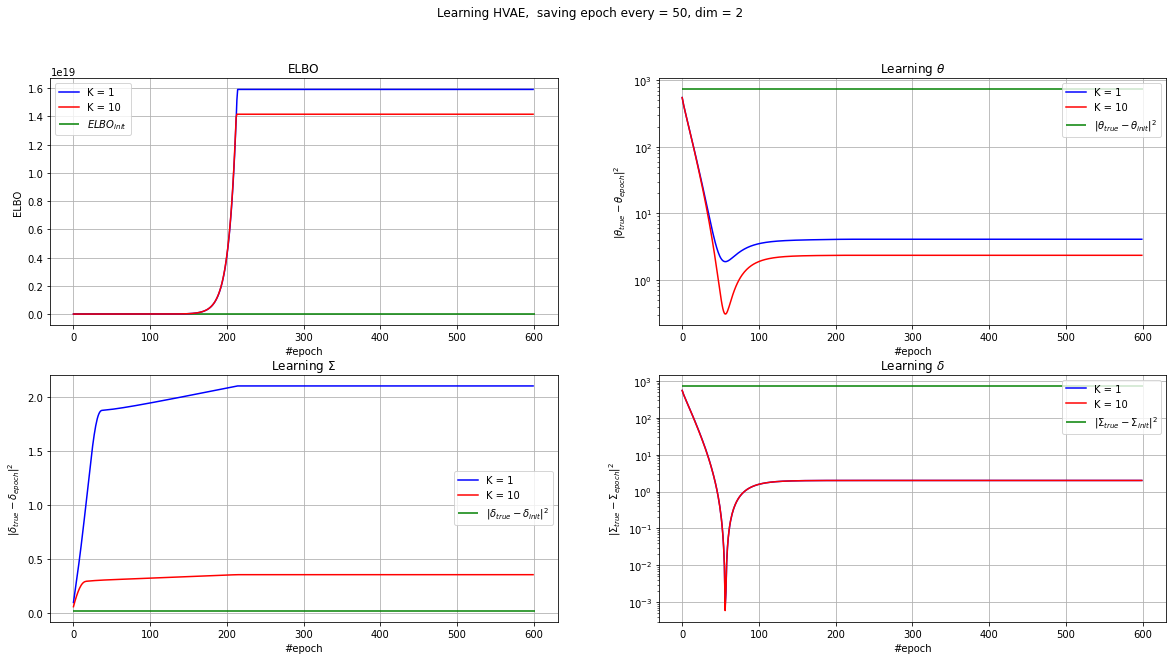

Init ELBO = 3451927.25, HVAE-1: result ELBO = 1.5897790247501562e+19, HVAE-2: result ELBO = 1.414364039166401e+19
Init diff theta = 728.5354614257812, HVAE-1: result diff theta = 4.0963239669799805, HVAE-2: result diff theta = 2.3503165245056152
Init diff delta = 0.020000001415610313, HVAE-1: result diff delta = 2.0978832244873047, HVAE-2: result diff theta = 0.35197341442108154
Init diff sigma = 728.5154418945312, HVAE-1: result diff sigma = 1.9984408617019653, HVAE-2: result diff theta = 1.9983429908752441


In [ ]:
diff_path = os.path.join('save', str(params['dims'][0]), 'HVAE_1_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo_1 = data['elbo']
     diff_delta_1 = data['diff_delta']
     diff_sigma_1 = data['diff_sigma']
     diff_1 = diff_delta_1 + diff_sigma_1

diff_path = os.path.join('save', str(params['dims'][0]), 'HVAE_2_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo_2 = data['elbo']
     diff_delta_2 = data['diff_delta']
     diff_sigma_2 = data['diff_sigma']
     diff_2 = diff_delta_2 + diff_sigma_2

fig, axs = plt.subplots(2, 2, figsize = (20, 10))
fig.suptitle(f"Learning HVAE,  saving epoch every = {params['save_every']}, dim = {2}")
axs[0, 0].set_xlabel("#epoch")
axs[0, 0].set_ylabel("ELBO")
axs[0, 1].set_xlabel("#epoch")
axs[0, 1].set_ylabel(r"$\|\theta_{true} - \theta_{epoch}\|^{2}$")
axs[1, 0].set_xlabel("#epoch")
axs[1, 0].set_ylabel("$\|\delta_{true} - \delta_{epoch}\|^{2}$")
axs[1, 1].set_xlabel("#epoch")
axs[1, 1].set_ylabel("$\|\Sigma_{true} - \Sigma_{epoch}\|^{2}$")
axs[0, 0].grid(True)
axs[0, 1].grid(True)
axs[1, 0].grid(True)
axs[1, 1].grid(True)
axs[0, 0].set_title('ELBO')
axs[0, 1].set_title(r'Learning $\theta$')
axs[1, 0].set_title(r'Learning $\Sigma$')
axs[1, 1].set_title(r'Learning $\delta$')
axs[0, 0].plot(elbo_1[1:], 'b', label = f"K = {params['HVAE_K_1']}")
axs[0, 0].plot(elbo_2[1:], 'r', label = f"K = {params['HVAE_K_2']}")
axs[0, 1].plot(diff_1[1:], 'b', label = f"K = {params['HVAE_K_1']}")
axs[0, 1].plot(diff_2[1:], 'r', label = f"K = {params['HVAE_K_2']}")
axs[1, 0].plot(diff_delta_1[1:], 'b', label = f"K = {params['HVAE_K_1']}")
axs[1, 0].plot(diff_delta_2[1:], 'r', label = f"K = {params['HVAE_K_2']}")
axs[1, 1].plot(diff_sigma_1[1:], 'b', label = f"K = {params['HVAE_K_1']}")
axs[1, 1].plot(diff_sigma_2[1:], 'r', label = f"K = {params['HVAE_K_2']}")
axs[0, 0].hlines(elbo_1[0], 0, len(elbo_1), 'g', label = r'$ELBO_{init}$')
axs[0, 1].hlines(diff_1[0], 0, len(diff_1), 'g', label = r'$\|\theta_{true} - \theta_{init}\|^{2}$')
axs[1, 0].hlines(diff_delta_1[0], 0, len(diff_delta_1), 'g', label = r'$\|\delta_{true} - \delta_{init}\|^{2}$')
axs[1, 1].hlines(diff_sigma_1[0], 0, len(diff_sigma_1), 'g', label = r'$\|\Sigma_{true} - \Sigma_{init}\|^{2}$')
axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 0].legend()
axs[1, 1].legend()
axs[0, 1].set_yscale('log')
#axs[1, 0].set_yscale('log')
axs[1, 1].set_yscale('log')
plt.show()
print(f"Init ELBO = {elbo_1[0]}, HVAE-1: result ELBO = {elbo_1[-1]}, HVAE-2: result ELBO = {elbo_2[-1]}")
print(f"Init diff theta = {diff_1[0]}, HVAE-1: result diff theta = {diff_1[-1]}, HVAE-2: result diff theta = {diff_2[-1]}")
print(f"Init diff delta = {diff_delta_1[0]}, HVAE-1: result diff delta = {diff_delta_1[-1]}, HVAE-2: result diff theta = {diff_delta_2[-1]}")
print(f"Init diff sigma = {diff_sigma_1[0]}, HVAE-1: result diff sigma = {diff_sigma_1[-1]}, HVAE-2: result diff theta = {diff_sigma_2[-1]}")

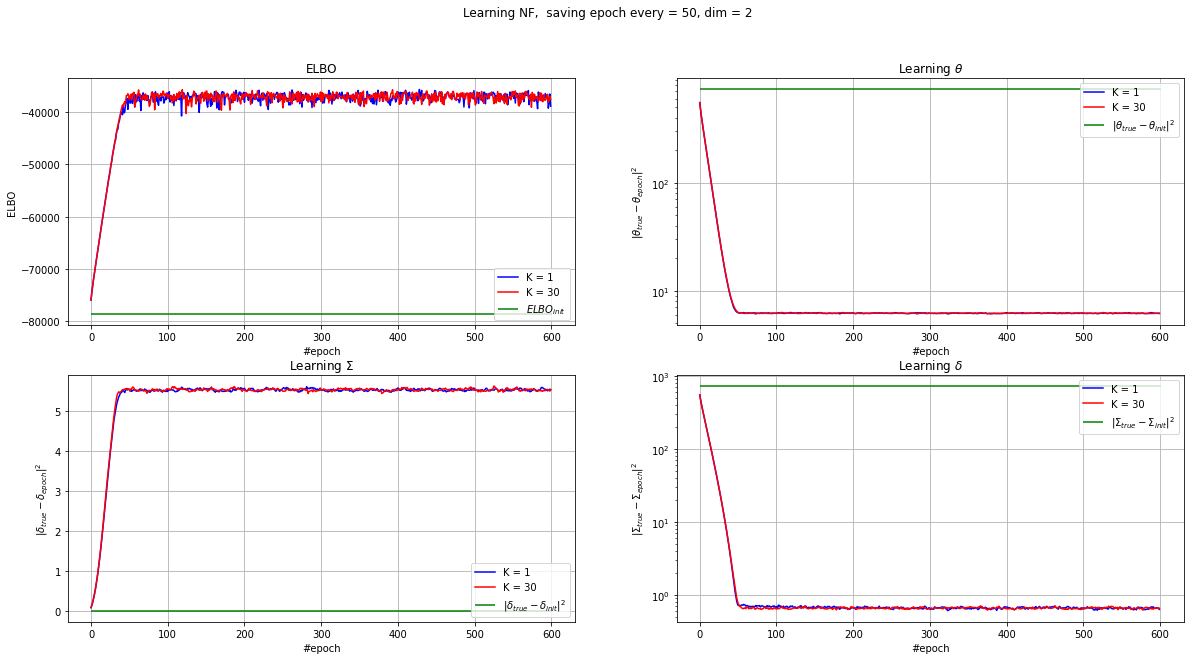

Init ELBO = -78584.90625, NF-1: result ELBO = -38951.34765625, NF-2: result ELBO = -37631.43359375
Init diff theta = 728.5354614257812, NFE-1: result diff theta = 6.155850410461426, NF-2: result diff theta = 6.186968803405762
Init diff delta = 0.020000001415610313, NF-1: result diff delta = 5.5262322425842285, NF-2: result diff theta = 5.53543758392334
Init diff sigma = 728.5154418945312, NF-1: result diff sigma = 0.6296179294586182, NF-2: result diff theta = 0.6515311598777771


In [ ]:
diff_path = os.path.join('save', str(params['dims'][0]), 'NF_1_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo_1 = data['elbo']
     diff_delta_1 = data['diff_delta']
     diff_sigma_1 = data['diff_sigma']
     diff_1 = diff_delta_1 + diff_sigma_1

diff_path = os.path.join('save', str(params['dims'][0]), 'NF_2_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo_2 = data['elbo']
     diff_delta_2 = data['diff_delta']
     diff_sigma_2 = data['diff_sigma']
     diff_2 = diff_delta_2 + diff_sigma_2

fig, axs = plt.subplots(2, 2, figsize = (20, 10))
fig.suptitle(f"Learning NF,  saving epoch every = {params['save_every']}, dim = {2}")
axs[0, 0].set_xlabel("#epoch")
axs[0, 0].set_ylabel("ELBO")
axs[0, 1].set_xlabel("#epoch")
axs[0, 1].set_ylabel(r"$\|\theta_{true} - \theta_{epoch}\|^{2}$")
axs[1, 0].set_xlabel("#epoch")
axs[1, 0].set_ylabel("$\|\delta_{true} - \delta_{epoch}\|^{2}$")
axs[1, 1].set_xlabel("#epoch")
axs[1, 1].set_ylabel("$\|\Sigma_{true} - \Sigma_{epoch}\|^{2}$")
axs[0, 0].grid(True)
axs[0, 1].grid(True)
axs[1, 0].grid(True)
axs[1, 1].grid(True)
axs[0, 0].set_title('ELBO')
axs[0, 1].set_title(r'Learning $\theta$')
axs[1, 0].set_title(r'Learning $\Sigma$')
axs[1, 1].set_title(r'Learning $\delta$')
axs[0, 0].plot(elbo_1[1:], 'b', label = f"K = {params['NF_K_1']}")
axs[0, 0].plot(elbo_2[1:], 'r', label = f"K = {params['NF_K_2']}")
axs[0, 1].plot(diff_1[1:], 'b', label = f"K = {params['NF_K_1']}")
axs[0, 1].plot(diff_2[1:], 'r', label = f"K = {params['NF_K_2']}")
axs[1, 0].plot(diff_delta_1[1:], 'b', label = f"K = {params['NF_K_1']}")
axs[1, 0].plot(diff_delta_2[1:], 'r', label = f"K = {params['NF_K_2']}")
axs[1, 1].plot(diff_sigma_1[1:], 'b', label = f"K = {params['NF_K_1']}")
axs[1, 1].plot(diff_sigma_2[1:], 'r', label = f"K = {params['NF_K_2']}")
axs[0, 0].hlines(elbo_1[0], 0, len(elbo_1), 'g', label = r'$ELBO_{init}$')
axs[0, 1].hlines(diff_1[0], 0, len(diff_1), 'g', label = r'$\|\theta_{true} - \theta_{init}\|^{2}$')
axs[1, 0].hlines(diff_delta_1[0], 0, len(diff_delta_1), 'g', label = r'$\|\delta_{true} - \delta_{init}\|^{2}$')
axs[1, 1].hlines(diff_sigma_1[0], 0, len(diff_sigma_1), 'g', label = r'$\|\Sigma_{true} - \Sigma_{init}\|^{2}$')
axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 0].legend()
axs[1, 1].legend()
axs[0, 1].set_yscale('log')
#axs[1, 0].set_yscale('log')
axs[1, 1].set_yscale('log')
plt.show()
print(f"Init ELBO = {elbo_1[0]}, NF-1: result ELBO = {elbo_1[-1]}, NF-2: result ELBO = {elbo_2[-1]}")
print(f"Init diff theta = {diff_1[0]}, NFE-1: result diff theta = {diff_1[-1]}, NF-2: result diff theta = {diff_2[-1]}")
print(f"Init diff delta = {diff_delta_1[0]}, NF-1: result diff delta = {diff_delta_1[-1]}, NF-2: result diff theta = {diff_delta_2[-1]}")
print(f"Init diff sigma = {diff_sigma_1[0]}, NF-1: result diff sigma = {diff_sigma_1[-1]}, NF-2: result diff theta = {diff_sigma_2[-1]}")

In [ ]:
def run_test(d, params, 
             batch_size=256,
             clip_value=None,
             dtype=torch.float32, 
             device=torch.device("cpu")):
    """ 
    Run the gaussian test with dimension d 
    """

    ######### Problem Specification

    # Data generation parameters
    prior_mu_z = torch.zeros(d, dtype=dtype)    # Prior mean
    prior_sigma_z = torch.eye(d, dtype=dtype)   # Prior covariance matrix

    # True model parameters
    num_range = torch.arange(-(d-1)/2, (d+1)/2, dtype=dtype)

    t_delta =  num_range / 5 

    print(f"true delta = {t_delta.numpy()}")

    if d == 1:
        t_sigma = torch.ones(1, dtype=dtype)
    else: 
        # Allow sigma to range from 0.1 to 1
        t_sigma = 36/(10*(d-1)**2) * num_range**2 + 0.1 
    print(f"true sigma = {t_sigma.numpy()}")

    ######### Variable Initialization

    # Initial model parameters - same across all methods
    init_delta = prior_mu_z.clone().to(device)
    init_log_sigma = 3 * torch.ones(d).to(device)

    # Initial HVAE variational parameters
    init_T = torch.tensor(5., dtype=dtype, device=device)
    init_eps = 0.005 * torch.ones(d, dtype=dtype)
    max_eps = params['max_eps'] * torch.ones(d, dtype=dtype)
    init_logit_eps = torch.log(init_eps/(max_eps - init_eps)).to(device)
    init_log_T_0 = torch.log(init_T - 1)

    # Initial NF variational parameters
    init_u_pre_reparam = torch.tensor(scipy.stats.truncnorm.rvs(-2, 2, 
                                                                scale=0.1, 
                                                                size=d),
                                      dtype=dtype, device=device)
    init_w = torch.tensor(scipy.stats.truncnorm.rvs(-2, 2, scale=0.1, size=d),
                          dtype=dtype, device=device)
    init_b = torch.tensor(0.1, dtype=dtype, device=device)

    # Initial VAE parameters
    init_mu_z = prior_mu_z.clone()
    init_log_sigma_z = torch.ones(d, dtype=dtype)

    ######### Set up models
    init_params = [[init_delta, init_log_sigma, init_logit_eps],
                   [init_delta, init_log_sigma, init_logit_eps]]
    
    HVAE_model_notemp_1 = HVAE(params,
        ['delta', 'log_sigma', 'logit_eps'],
        init_params[0], 
        'HVAE_notemp_1', d, params['HVAE_K_1'])
    HVAE_model_notemp_2 = HVAE(params,
        ['delta', 'log_sigma', 'logit_eps'], 
        init_params[1],
        'HVAE_notemp_2', d, params['HVAE_K_2'])

    #model_list = [HVAE_model_1, HVAE_model_2, NF_model_1]
    #model_list = [HVAE_model_1, NF_model_1]
    model_list = [HVAE_model_notemp_1, HVAE_model_notemp_2]

    print("Models were initialized!")
    
    ######### Generate Training Data & Save - One for each test

    train_data_list = []

    for i in range(params['n_tests']):
        z = MultivariateNormal(prior_mu_z, prior_sigma_z).sample()
        x = MultivariateNormal(z + t_delta, 
                               torch.diag(t_sigma**2)).sample([params['n_data']])
        x = x.to(device)
        train_data_list.append(x)

    # Folder should have already been created in the initializations
    data_path = os.path.join('save', str(d), 'train_data.p')
    pickle.dump(train_data_list, open(data_path, 'wb')) 

    # Store the final parameter values for all test runs in this dictionary
    final_params = {}

    for i in range(len(model_list)):
        final_values = []
        m = model_list[i]
        model_init_params = init_params[i]

        for j in range(params['n_tests']):
            print("------------------------------------------------------")
            print(f"Test = {j}")
            print("------------------------------------------------------")
            m._reinitialize(model_init_params)
            gaussian_data = gaussian_dataset(train_data_list[j])
            train_dataloader = DataLoader(gaussian_data, batch_size=batch_size,
                                          shuffle=False, num_workers=0)
            (delta, sigma) = m.train(train_dataloader, j, 
                                     t_delta, t_sigma,
                                     clip_value)
            final_values.append((delta, sigma))

        final_params[m.model_name] = final_values.copy()

    ######### Test models using difference between parameters

    param_diffs = {}

    for m in model_list:
        
        diffs = []

        for i in range(params['n_tests']):
            delta = final_params[m.model_name][i][0]
            sigma = final_params[m.model_name][i][1]

            delta_diff = np.sum((delta - t_delta.numpy())**2)
            sigma_diff = np.sum((sigma - t_sigma.numpy())**2)
            theta_diff = delta_diff + sigma_diff
            print(f"Model {m.model_name}, test = {i}, result delta diff = {delta_diff}")
            print(f"Model {m.model_name}, test = {i}, result sigma diff = {sigma_diff}")
            print(f"Model {m.model_name}, test = {i}, result theta diff = {theta_diff}")

            diffs.append((delta_diff, sigma_diff, theta_diff))

        param_diffs[m.model_name] = diffs.copy()

    # Save parameter differences in a pickle file
    diff_path = os.path.join('save', str(d), 'all_diffs.p')
    pickle.dump(param_diffs, open(diff_path, 'wb'))

In [ ]:
device = torch.device("cuda")
dtype = torch.float32
clip_value = None
batch_size = 256

In [ ]:
params = {

    # PROBLEM SPECIFICATION
    #'dims': [1, 2, 3, 5, 11, 25, 51, 101, 201, 301], # Dimensions to test
    'dims': [50],
    'n_data': 10000,                                 # Number of data points

    # TEST HYPERPARAMETERS
    'n_tests': 3,      # Number of experiments to run

    # GLOBAL OPTIMIZATION PARAMETERS
    'n_iter': 2000,    # Number of optimization iterations
    'n_batch': 10,      # Number of points for ELBO estimate
    'rms_eta': 0.001,   # Stepsize for RMSProp
    'save_every': 20,   # Save parameter information every so often
    'print_every': 20, # Print less often than save

    # HVAE HYPERPARAMETERS
    'HVAE_K_1': 1,    # Number of leapfrog/cooling steps for HVAE flow 1
    'HVAE_K_2': 10,   # Number of leapfrog/cooling steps for HVAE flow 2
    'max_eps': 0.5,   # Maximum leapfrog step size per dimension 

    # NF HYPERPARAMETERS
    'NF_K_1': 1,    # Number of flow steps for NF flow 1
    'NF_K_2': 30,   # Number of flow steps for NF flow 2
    
}

In [ ]:
dims = params['dims']
seed = 12345
np.random.seed(seed)
torch.manual_seed(seed)
for d in dims:
    print('**** Running test for d={0:d} ****'.format(d))
    run_test(d, params, batch_size, clip_value, dtype, device)

**** Running test for d=50 ****
true delta = [-4.9 -4.7 -4.5 -4.3 -4.1 -3.9 -3.7 -3.5 -3.3 -3.1 -2.9 -2.7 -2.5 -2.3
 -2.1 -1.9 -1.7 -1.5 -1.3 -1.1 -0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5
  0.7  0.9  1.1  1.3  1.5  1.7  1.9  2.1  2.3  2.5  2.7  2.9  3.1  3.3
  3.5  3.7  3.9  4.1  4.3  4.5  4.7  4.9]
true sigma = [1.         0.92803    0.85905874 0.79308623 0.73011243 0.67013747
 0.6131612  0.55918366 0.50820494 0.4602249  0.41524363 0.37326112
 0.3342774  0.29829237 0.26530612 0.2353186  0.20832986 0.18433985
 0.16334862 0.1453561  0.13036235 0.11836734 0.1093711  0.10337359
 0.10037485 0.10037485 0.10337359 0.1093711  0.11836734 0.13036235
 0.1453561  0.16334862 0.18433985 0.20832986 0.2353186  0.26530612
 0.29829237 0.3342774  0.37326112 0.41524363 0.4602249  0.50820494
 0.55918366 0.6131612  0.67013747 0.73011243 0.79308623 0.85905874
 0.92803    1.        ]
Models were initialized!
------------------------------------------------------
Test = 0
--------------------------------------

In [ ]:
model_names = ['HVAE_notemp_1', 'HVAE_notemp_2']
diff_delta_results = {}
diff_sigma_results = {}
diff_results = {}
for name in model_names:
    diff_delta_tests = np.zeros(params['n_tests'])
    diff_sigma_tests = np.zeros(params['n_tests'])
    diff_tests = np.zeros(params['n_tests'])
    for i in range(params['n_tests']):
        file_name = name + '_train_' + str(i) + '.p'
        diff_path = os.path.join('save', str(params['dims'][0]), file_name)
        with open(diff_path, 'rb') as f:
            data = pickle.load(f)
            elbo = data['elbo']
            diff_delta = data['diff_delta']
            diff_sigma = data['diff_sigma']
            diff = diff_delta + diff_sigma
            diff_delta_is_not_nan = diff_delta[~np.isnan(diff_delta)]
            diff_sigma_is_not_nan = diff_sigma[~np.isnan(diff_sigma)]
            diff_is_not_nan = diff[~np.isnan(diff)]
            diff_delta_tests[i] = diff_delta_is_not_nan[-1]
            diff_sigma_tests[i] = diff_sigma_is_not_nan[-1]
            diff_tests[i] = diff_is_not_nan[-1]
    diff_delta_results[name] = diff_delta_tests
    diff_sigma_results[name] = diff_sigma_tests
    diff_results[name] = diff_tests
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, diff delta = {diff_delta_tests}")
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, diff sigma = {diff_sigma_tests}")
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, diff = {diff_tests}")

Model = HVAE_notemp_1, dimensionality = 50, diff delta = [56.03353119 36.37197495 60.9890976 ]
Model = HVAE_notemp_1, dimensionality = 50, diff sigma = [7.98554373 8.01743698 7.98185682]
Model = HVAE_notemp_1, dimensionality = 50, diff = [64.01907349 44.38941193 68.9709549 ]
Model = HVAE_notemp_2, dimensionality = 50, diff delta = [55.82462692 36.26421738 60.91970444]
Model = HVAE_notemp_2, dimensionality = 50, diff sigma = [25.28292656 25.24619102 25.51254463]
Model = HVAE_notemp_2, dimensionality = 50, diff = [81.10755157 61.51040649 86.43225098]


In [ ]:
for name in model_names:
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, mean diff delta = {diff_delta_results[name].mean()}")
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, mean diff sigma = {diff_sigma_results[name].mean()}")
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, mean diff = {diff_results[name].mean()}")

Model = HVAE_notemp_1, dimensionality = 50, mean diff delta = 51.131534576416016
Model = HVAE_notemp_1, dimensionality = 50, mean diff sigma = 7.994945844014485
Model = HVAE_notemp_1, dimensionality = 50, mean diff = 59.12648010253906
Model = HVAE_notemp_2, dimensionality = 50, mean diff delta = 51.00284957885742
Model = HVAE_notemp_2, dimensionality = 50, mean diff sigma = 25.34722073872884
Model = HVAE_notemp_2, dimensionality = 50, mean diff = 76.35006968180339


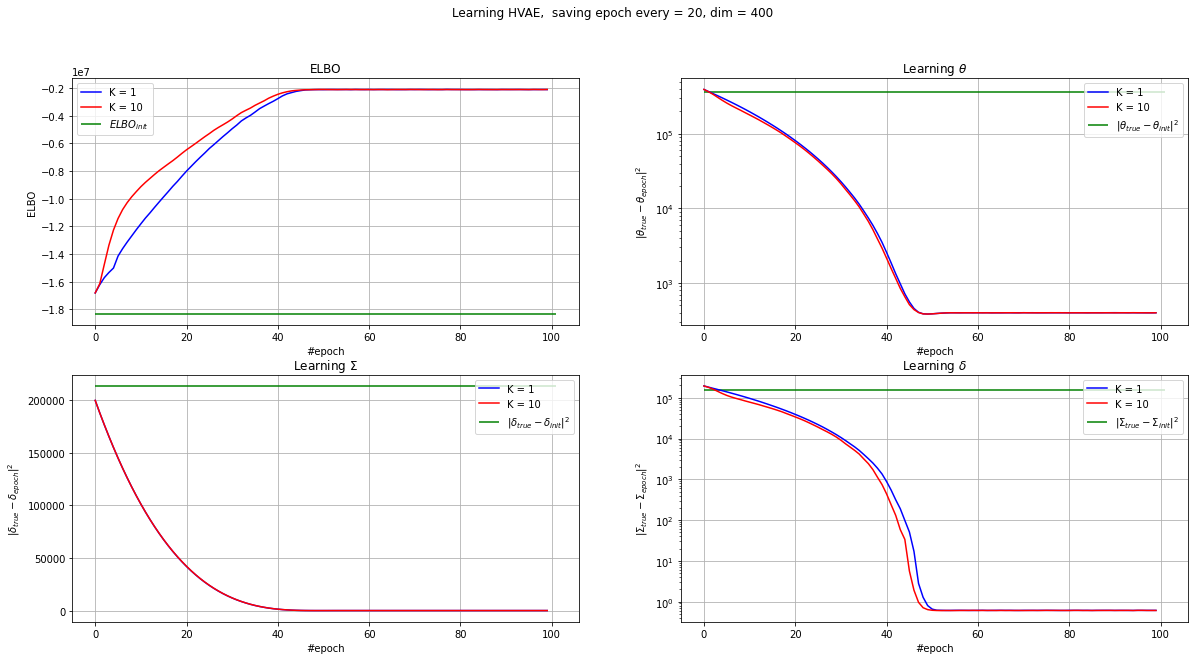

Init ELBO = -18341708.0, HVAE-1: result ELBO = -2107367.75, HVAE-2: result ELBO = -2098433.25
Init diff theta = 368345.53125, HVAE-1: result diff theta = 398.84173583984375, HVAE-2: result diff theta = 398.55535888671875
Init diff delta = 213331.984375, HVAE-1: result diff delta = 398.23248291015625, HVAE-2: result diff theta = 397.948486328125
Init diff sigma = 155013.546875, HVAE-1: result diff sigma = 0.6092437505722046, HVAE-2: result diff theta = 0.6068632006645203


In [ ]:
diff_path = os.path.join('save', str(400), 'HVAE_1_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo_1 = data['elbo']
     diff_delta_1 = data['diff_delta']
     diff_sigma_1 = data['diff_sigma']
     diff_1 = diff_delta_1 + diff_sigma_1

diff_path = os.path.join('save', str(400), 'HVAE_2_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo_2 = data['elbo']
     diff_delta_2 = data['diff_delta']
     diff_sigma_2 = data['diff_sigma']
     diff_2 = diff_delta_2 + diff_sigma_2

diff_path = os.path.join('save', str(400), 'NF_1_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo_3 = data['elbo']
     diff_delta_3 = data['diff_delta']
     diff_sigma_3 = data['diff_sigma']
     diff_3 = diff_delta_3 + diff_sigma_3

diff_path = os.path.join('save', str(400), 'NF_2_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo_4 = data['elbo']
     diff_delta_4 = data['diff_delta']
     diff_sigma_4 = data['diff_sigma']
     diff_4 = diff_delta_4 + diff_sigma_4

     

fig, axs = plt.subplots(2, 2, figsize = (20, 10))
fig.suptitle(f"Learning process,  saving epoch every = {20}, dim = {400}")
axs[0, 0].set_xlabel("#epoch")
axs[0, 0].set_ylabel("ELBO")
axs[0, 1].set_xlabel("#epoch")
axs[0, 1].set_ylabel(r"$\|\theta_{true} - \theta_{epoch}\|^{2}$")
axs[1, 0].set_xlabel("#epoch")
axs[1, 0].set_ylabel("$\|\delta_{true} - \delta_{epoch}\|^{2}$")
axs[1, 1].set_xlabel("#epoch")
axs[1, 1].set_ylabel("$\|\Sigma_{true} - \Sigma_{epoch}\|^{2}$")
axs[0, 0].grid(True)
axs[0, 1].grid(True)
axs[1, 0].grid(True)
axs[1, 1].grid(True)
axs[0, 0].set_title('ELBO')
axs[0, 1].set_title(r'Learning $\theta$')
axs[1, 0].set_title(r'Learning $\Sigma$')
axs[1, 1].set_title(r'Learning $\delta$')
axs[0, 0].plot(elbo_1[1:], 'b', label = f"HVAE, K = {1}")
axs[0, 0].plot(elbo_2[1:], 'r', label = f"HVAE, K = {10}")
axs[0, 1].plot(diff_1[1:], 'b', label = f"HVAE, K = {1}")
axs[0, 1].plot(diff_2[1:], 'r', label = f"HVAE, K = {10}")
axs[0, 0].plot(elbo_3[1:], 'g', label = f"NF, K = {1}")
axs[0, 0].plot(elbo_4[1:], 'black', label = f"NF, K = {30}")
axs[0, 1].plot(diff_3[1:], 'g', label = f"NF, K = {1}")
axs[0, 1].plot(diff_4[1:], 'black', label = f"NF, K = {30}")
axs[1, 0].plot(diff_delta_1[1:], 'b', label = f"HVAE, K = {1}")
axs[1, 0].plot(diff_delta_2[1:], 'r', label = f"HVAE, K = {10}")
axs[1, 1].plot(diff_sigma_1[1:], 'b', label = f"HVAE, K = {1}")
axs[1, 1].plot(diff_sigma_2[1:], 'r', label = f"HVAE, K = {10}")
axs[1, 0].plot(diff_delta_3[1:], 'g', label = f"NF, K = {1}")
axs[1, 0].plot(diff_delta_4[1:], 'black', label = f"NF, K = {30}")
axs[1, 1].plot(diff_sigma_3[1:], 'g', label = f"NF, K = {1}")
axs[1, 1].plot(diff_sigma_4[1:], 'black', label = f"NF, K = {30}")
axs[0, 0].hlines(elbo_1[0], 0, len(elbo_1), 'g', label = r'$ELBO_{init}$')
axs[0, 1].hlines(diff_1[0], 0, len(diff_1), 'g', label = r'$\|\theta_{true} - \theta_{init}\|^{2}$')
axs[1, 0].hlines(diff_delta_1[0], 0, len(diff_delta_1), 'g', label = r'$\|\Delta_{true} - \Delta_{init}\|^{2}$')
axs[1, 1].hlines(diff_sigma_1[0], 0, len(diff_sigma_1), 'g', label = r'$\|\Sigma_{true} - \Sigma_{init}\|^{2}$')
axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 0].legend()
axs[1, 1].legend()
axs[0, 1].set_yscale('log')
#axs[1, 0].set_yscale('log')
axs[1, 1].set_yscale('log')
plt.show()
print(f"Init ELBO = {elbo_1[0]}, HVAE-1: result ELBO = {elbo_1[-1]}, HVAE-2: result ELBO = {elbo_2[-1]}")
print(f"Init diff theta = {diff_1[0]}, HVAE-1: result diff theta = {diff_1[-1]}, HVAE-2: result diff theta = {diff_2[-1]}")
print(f"Init diff delta = {diff_delta_1[0]}, HVAE-1: result diff delta = {diff_delta_1[-1]}, HVAE-2: result diff theta = {diff_delta_2[-1]}")
print(f"Init diff sigma = {diff_sigma_1[0]}, HVAE-1: result diff sigma = {diff_sigma_1[-1]}, HVAE-2: result diff theta = {diff_sigma_2[-1]}")

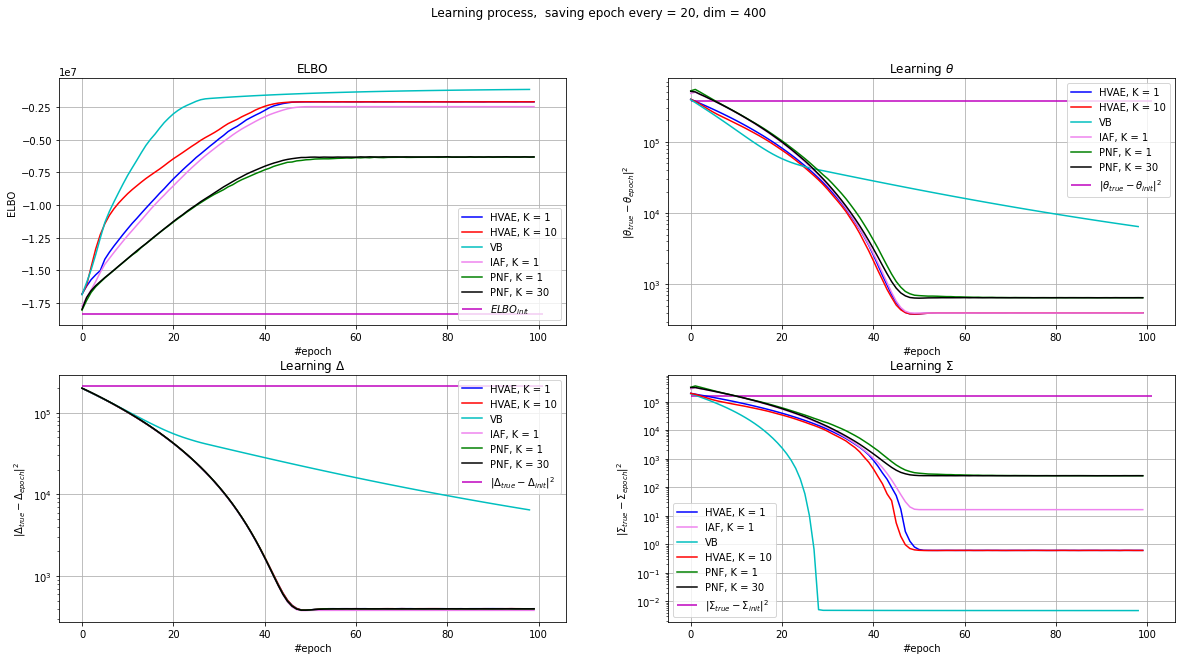

Init ELBO = -18341708.0, HVAE-1: result ELBO = -2107367.75, HVAE-2: result ELBO = -2098433.25
Init diff theta = 368345.53125, HVAE-1: result diff theta = 398.84173583984375, HVAE-2: result diff theta = 398.55535888671875
Init diff delta = 213331.984375, HVAE-1: result diff delta = 398.23248291015625, HVAE-2: result diff theta = 397.948486328125
Init diff sigma = 155013.546875, HVAE-1: result diff sigma = 0.6092437505722046, HVAE-2: result diff theta = 0.6068632006645203


In [18]:
import os
import pickle
import matplotlib.pyplot as plt

diff_path = os.path.join('save', str(400), 'HVAE_1_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo_1 = data['elbo']
     diff_delta_1 = data['diff_delta']
     diff_sigma_1 = data['diff_sigma']
     diff_1 = diff_delta_1 + diff_sigma_1

diff_path = os.path.join('save', str(400), 'HVAE_2_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo_2 = data['elbo']
     diff_delta_2 = data['diff_delta']
     diff_sigma_2 = data['diff_sigma']
     diff_2 = diff_delta_2 + diff_sigma_2

diff_path = os.path.join('save', str(400), 'NF_1_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo_3 = data['elbo']
     diff_delta_3 = data['diff_delta']
     diff_sigma_3 = data['diff_sigma']
     diff_3 = diff_delta_3 + diff_sigma_3

diff_path = os.path.join('save', str(400), 'NF_2_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo_4 = data['elbo']
     diff_delta_4 = data['diff_delta']
     diff_sigma_4 = data['diff_sigma']
     diff_4 = diff_delta_4 + diff_sigma_4

diff_path = os.path.join('save', str(400), 'VB_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo_5 = data['elbo'][:100]
     diff_delta_5 = data['diff_delta'][:100]
     diff_sigma_5 = data['diff_sigma'][:100]
     diff_5 = diff_delta_5 + diff_sigma_5

diff_path = os.path.join('save', str(400), 'IAF_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo_6 = data['elbo']
     diff_delta_6 = data['diff_delta']
     diff_sigma_6 = data['diff_sigma']
     diff_6 = diff_delta_6 + diff_sigma_6

fig, axs = plt.subplots(2, 2, figsize = (20, 10))
fig.suptitle(f"Learning process,  saving epoch every = {20}, dim = {400}")
axs[0, 0].set_xlabel("#epoch")
axs[0, 0].set_ylabel("ELBO")
axs[0, 1].set_xlabel("#epoch")
axs[0, 1].set_ylabel(r"$\|\theta_{true} - \theta_{epoch}\|^{2}$")
axs[1, 0].set_xlabel("#epoch")
axs[1, 0].set_ylabel("$\|\Delta_{true} - \Delta_{epoch}\|^{2}$")
axs[1, 1].set_xlabel("#epoch")
axs[1, 1].set_ylabel("$\|\Sigma_{true} - \Sigma_{epoch}\|^{2}$")
axs[0, 0].grid(True)
axs[0, 1].grid(True)
axs[1, 0].grid(True)
axs[1, 1].grid(True)
axs[0, 0].set_title('ELBO')
axs[0, 1].set_title(r'Learning $\theta$')
axs[1, 0].set_title(r'Learning $\Delta$')
axs[1, 1].set_title(r'Learning $\Sigma$')
axs[0, 0].plot(elbo_1[1:], 'b', label = f"HVAE, K = {1}")
axs[0, 0].plot(elbo_2[1:], 'r', label = f"HVAE, K = {10}")
axs[0, 0].plot(elbo_5[1:], 'c', label = f"VB")
axs[0, 0].plot(elbo_6[1:], 'violet', label = f"IAF, K = {1}")
axs[0, 1].plot(diff_1[1:], 'b', label = f"HVAE, K = {1}")
axs[0, 1].plot(diff_2[1:], 'r', label = f"HVAE, K = {10}")
axs[0, 1].plot(diff_5[1:], 'c', label = f"VB")
axs[0, 1].plot(diff_6[1:], 'violet', label = f"IAF, K = {1}")
axs[0, 0].plot(elbo_3[1:], 'g', label = f"PNF, K = {1}")
axs[0, 0].plot(elbo_4[1:], 'black', label = f"PNF, K = {30}")
axs[0, 1].plot(diff_3[1:], 'g', label = f"PNF, K = {1}")
axs[0, 1].plot(diff_4[1:], 'black', label = f"PNF, K = {30}")
axs[1, 0].plot(diff_delta_1[1:], 'b', label = f"HVAE, K = {1}")
axs[1, 0].plot(diff_delta_2[1:], 'r', label = f"HVAE, K = {10}")
axs[1, 0].plot(diff_delta_5[1:], 'c', label = f"VB")
axs[1, 0].plot(diff_delta_6[1:], 'violet', label = f"IAF, K = {1}")
axs[1, 1].plot(diff_sigma_1[1:], 'b', label = f"HVAE, K = {1}")
axs[1, 1].plot(diff_sigma_6[1:], 'violet', label = f"IAF, K = {1}")
axs[1, 1].plot(diff_sigma_5[1:], 'c', label = f"VB")
axs[1, 1].plot(diff_sigma_2[1:], 'r', label = f"HVAE, K = {10}")
axs[1, 0].plot(diff_delta_3[1:], 'g', label = f"PNF, K = {1}")
axs[1, 0].plot(diff_delta_4[1:], 'black', label = f"PNF, K = {30}")
axs[1, 1].plot(diff_sigma_3[1:], 'g', label = f"PNF, K = {1}")
axs[1, 1].plot(diff_sigma_4[1:], 'black', label = f"PNF, K = {30}")
axs[0, 0].hlines(elbo_1[0], 0, len(elbo_1), 'm', label = r'$ELBO_{init}$')
axs[0, 1].hlines(diff_1[0], 0, len(diff_1), 'm', label = r'$\|\theta_{true} - \theta_{init}\|^{2}$')
axs[1, 0].hlines(diff_delta_1[0], 0, len(diff_delta_1), 'm', label = r'$\|\Delta_{true} - \Delta_{init}\|^{2}$')
axs[1, 1].hlines(diff_sigma_1[0], 0, len(diff_sigma_1), 'm', label = r'$\|\Sigma_{true} - \Sigma_{init}\|^{2}$')
axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 0].legend()
axs[1, 1].legend()
axs[0, 1].set_yscale('log')
#axs[1, 0].set_yscale('log')
axs[1, 1].set_yscale('log')
axs[1, 0].set_yscale('log')
plt.show()
print(f"Init ELBO = {elbo_1[0]}, HVAE-1: result ELBO = {elbo_1[-1]}, HVAE-2: result ELBO = {elbo_2[-1]}")
print(f"Init diff theta = {diff_1[0]}, HVAE-1: result diff theta = {diff_1[-1]}, HVAE-2: result diff theta = {diff_2[-1]}")
print(f"Init diff delta = {diff_delta_1[0]}, HVAE-1: result diff delta = {diff_delta_1[-1]}, HVAE-2: result diff theta = {diff_delta_2[-1]}")
print(f"Init diff sigma = {diff_sigma_1[0]}, HVAE-1: result diff sigma = {diff_sigma_1[-1]}, HVAE-2: result diff theta = {diff_sigma_2[-1]}")

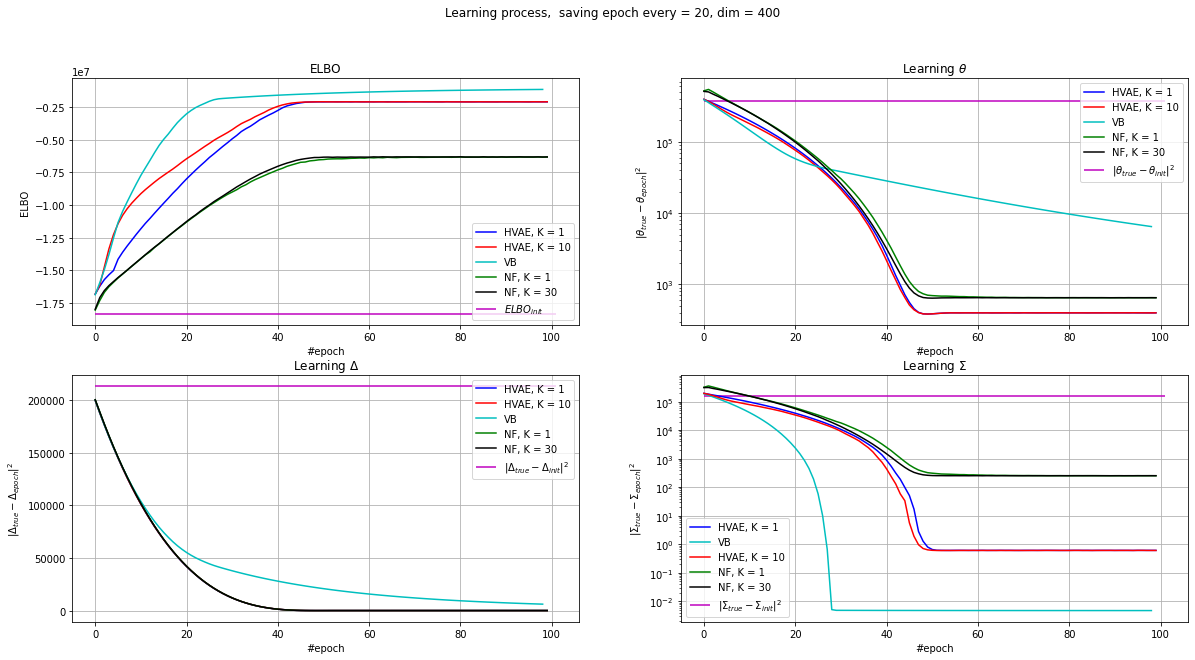

Init ELBO = -18341708.0, HVAE-1: result ELBO = -2107367.75, HVAE-2: result ELBO = -2098433.25
Init diff theta = 368345.53125, HVAE-1: result diff theta = 398.84173583984375, HVAE-2: result diff theta = 398.55535888671875
Init diff delta = 213331.984375, HVAE-1: result diff delta = 398.23248291015625, HVAE-2: result diff theta = 397.948486328125
Init diff sigma = 155013.546875, HVAE-1: result diff sigma = 0.6092437505722046, HVAE-2: result diff theta = 0.6068632006645203


In [10]:
import os
import pickle
import matplotlib.pyplot as plt

diff_path = os.path.join('save', str(400), 'HVAE_1_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo_1 = data['elbo']
     diff_delta_1 = data['diff_delta']
     diff_sigma_1 = data['diff_sigma']
     diff_1 = diff_delta_1 + diff_sigma_1

diff_path = os.path.join('save', str(400), 'HVAE_2_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo_2 = data['elbo']
     diff_delta_2 = data['diff_delta']
     diff_sigma_2 = data['diff_sigma']
     diff_2 = diff_delta_2 + diff_sigma_2

diff_path = os.path.join('save', str(400), 'NF_1_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo_3 = data['elbo']
     diff_delta_3 = data['diff_delta']
     diff_sigma_3 = data['diff_sigma']
     diff_3 = diff_delta_3 + diff_sigma_3

diff_path = os.path.join('save', str(400), 'NF_2_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo_4 = data['elbo']
     diff_delta_4 = data['diff_delta']
     diff_sigma_4 = data['diff_sigma']
     diff_4 = diff_delta_4 + diff_sigma_4

diff_path = os.path.join('save', str(400), 'VB_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo_5 = data['elbo'][:100]
     diff_delta_5 = data['diff_delta'][:100]
     diff_sigma_5 = data['diff_sigma'][:100]
     diff_5 = diff_delta_5 + diff_sigma_5

diff_path = os.path.join('save', str(400), 'IAF_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo_6 = data['elbo']
     diff_delta_6 = data['diff_delta']
     diff_sigma_6 = data['diff_sigma']
     diff_6 = diff_delta_6 + diff_sigma_6

fig, axs = plt.subplots(2, 2, figsize = (20, 10))
fig.suptitle(f"Learning process,  saving epoch every = {20}, dim = {400}")
axs[0, 0].set_xlabel("#epoch")
axs[0, 0].set_ylabel("ELBO")
axs[0, 1].set_xlabel("#epoch")
axs[0, 1].set_ylabel(r"$\|\theta_{true} - \theta_{epoch}\|^{2}$")
axs[1, 0].set_xlabel("#epoch")
axs[1, 0].set_ylabel("$\|\Delta_{true} - \Delta_{epoch}\|^{2}$")
axs[1, 1].set_xlabel("#epoch")
axs[1, 1].set_ylabel("$\|\Sigma_{true} - \Sigma_{epoch}\|^{2}$")
axs[0, 0].grid(True)
axs[0, 1].grid(True)
axs[1, 0].grid(True)
axs[1, 1].grid(True)
axs[0, 0].set_title('ELBO')
axs[0, 1].set_title(r'Learning $\theta$')
axs[1, 0].set_title(r'Learning $\Delta$')
axs[1, 1].set_title(r'Learning $\Sigma$')
axs[0, 0].plot(elbo_1[1:], 'b', label = f"HVAE, K = {1}")
axs[0, 0].plot(elbo_2[1:], 'r', label = f"HVAE, K = {10}")
axs[0, 0].plot(elbo_5[1:], 'c', label = f"VB")
axs[0, 0].plot(elbo_6[1:], 'violet', label = f"IAF, K = {1}")
axs[0, 1].plot(diff_1[1:], 'b', label = f"HVAE, K = {1}")
axs[0, 1].plot(diff_2[1:], 'r', label = f"HVAE, K = {10}")
axs[0, 1].plot(diff_5[1:], 'c', label = f"VB")
axs[0, 1].plot(diff_6[1:], 'violet', label = f"IAF, K = {1}")
axs[0, 0].plot(elbo_3[1:], 'g', label = f"NF, K = {1}")
axs[0, 0].plot(elbo_4[1:], 'black', label = f"NF, K = {30}")
axs[0, 1].plot(diff_3[1:], 'g', label = f"NF, K = {1}")
axs[0, 1].plot(diff_4[1:], 'black', label = f"NF, K = {30}")
axs[1, 0].plot(diff_delta_1[1:], 'b', label = f"HVAE, K = {1}")
axs[1, 0].plot(diff_delta_2[1:], 'r', label = f"HVAE, K = {10}")
axs[1, 0].plot(diff_delta_5[1:], 'c', label = f"VB")
axs[1, 0].plot(diff_delta_6[1:], 'violet', label = f"IAF, K = {1}")
axs[1, 1].plot(diff_sigma_1[1:], 'b', label = f"HVAE, K = {1}")
axs[1, 1].plot(diff_sigma_6[1:], 'violet', label = f"IAF, K = {1}")
axs[1, 1].plot(diff_sigma_5[1:], 'c', label = f"VB")
axs[1, 1].plot(diff_sigma_2[1:], 'r', label = f"HVAE, K = {10}")
axs[1, 0].plot(diff_delta_3[1:], 'g', label = f"NF, K = {1}")
axs[1, 0].plot(diff_delta_4[1:], 'black', label = f"NF, K = {30}")
axs[1, 1].plot(diff_sigma_3[1:], 'g', label = f"NF, K = {1}")
axs[1, 1].plot(diff_sigma_4[1:], 'black', label = f"NF, K = {30}")
axs[0, 0].hlines(elbo_1[0], 0, len(elbo_1), 'm', label = r'$ELBO_{init}$')
axs[0, 1].hlines(diff_1[0], 0, len(diff_1), 'm', label = r'$\|\theta_{true} - \theta_{init}\|^{2}$')
axs[1, 0].hlines(diff_delta_1[0], 0, len(diff_delta_1), 'm', label = r'$\|\Delta_{true} - \Delta_{init}\|^{2}$')
axs[1, 1].hlines(diff_sigma_1[0], 0, len(diff_sigma_1), 'm', label = r'$\|\Sigma_{true} - \Sigma_{init}\|^{2}$')
axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 0].legend()
axs[1, 1].legend()
axs[0, 1].set_yscale('log')
#axs[1, 0].set_yscale('log')
axs[1, 1].set_yscale('log')
plt.show()
print(f"Init ELBO = {elbo_1[0]}, HVAE-1: result ELBO = {elbo_1[-1]}, HVAE-2: result ELBO = {elbo_2[-1]}")
print(f"Init diff theta = {diff_1[0]}, HVAE-1: result diff theta = {diff_1[-1]}, HVAE-2: result diff theta = {diff_2[-1]}")
print(f"Init diff delta = {diff_delta_1[0]}, HVAE-1: result diff delta = {diff_delta_1[-1]}, HVAE-2: result diff theta = {diff_delta_2[-1]}")
print(f"Init diff sigma = {diff_sigma_1[0]}, HVAE-1: result diff sigma = {diff_sigma_1[-1]}, HVAE-2: result diff theta = {diff_sigma_2[-1]}")

In [ ]:
diff_path = os.path.join('save', str(params['dims'][0]), 'NF_1_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo_1 = data['elbo']
     diff_delta_1 = data['diff_delta']
     diff_sigma_1 = data['diff_sigma']
     diff_1 = diff_delta_1 + diff_sigma_1

diff_path = os.path.join('save', str(params['dims'][0]), 'NF_2_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo_2 = data['elbo']
     diff_delta_2 = data['diff_delta']
     diff_sigma_2 = data['diff_sigma']
     diff_2 = diff_delta_2 + diff_sigma_2

fig, axs = plt.subplots(2, 2, figsize = (20, 10))
fig.suptitle(f"Learning NF,  saving epoch every = {params['save_every']}, dim = {2}")
axs[0, 0].set_xlabel("#epoch")
axs[0, 0].set_ylabel("ELBO")
axs[0, 1].set_xlabel("#epoch")
axs[0, 1].set_ylabel(r"$\|\theta_{true} - \theta_{epoch}\|^{2}$")
axs[1, 0].set_xlabel("#epoch")
axs[1, 0].set_ylabel("$\|\delta_{true} - \delta_{epoch}\|^{2}$")
axs[1, 1].set_xlabel("#epoch")
axs[1, 1].set_ylabel("$\|\Sigma_{true} - \Sigma_{epoch}\|^{2}$")
axs[0, 0].grid(True)
axs[0, 1].grid(True)
axs[1, 0].grid(True)
axs[1, 1].grid(True)
axs[0, 0].set_title('ELBO')
axs[0, 1].set_title(r'Learning $\theta$')
axs[1, 0].set_title(r'Learning $\Sigma$')
axs[1, 1].set_title(r'Learning $\delta$')
axs[0, 0].plot(elbo_1[1:], 'b', label = f"K = {params['NF_K_1']}")
axs[0, 0].plot(elbo_2[1:], 'r', label = f"K = {params['NF_K_2']}")
axs[0, 1].plot(diff_1[1:], 'b', label = f"K = {params['NF_K_1']}")
axs[0, 1].plot(diff_2[1:], 'r', label = f"K = {params['NF_K_2']}")
axs[1, 0].plot(diff_delta_1[1:], 'b', label = f"K = {params['NF_K_1']}")
axs[1, 0].plot(diff_delta_2[1:], 'r', label = f"K = {params['NF_K_2']}")
axs[1, 1].plot(diff_sigma_1[1:], 'b', label = f"K = {params['NF_K_1']}")
axs[1, 1].plot(diff_sigma_2[1:], 'r', label = f"K = {params['NF_K_2']}")
axs[0, 0].hlines(elbo_1[0], 0, len(elbo_1), 'g', label = r'$ELBO_{init}$')
axs[0, 1].hlines(diff_1[0], 0, len(diff_1), 'g', label = r'$\|\theta_{true} - \theta_{init}\|^{2}$')
axs[1, 0].hlines(diff_delta_1[0], 0, len(diff_delta_1), 'g', label = r'$\|\delta_{true} - \delta_{init}\|^{2}$')
axs[1, 1].hlines(diff_sigma_1[0], 0, len(diff_sigma_1), 'g', label = r'$\|\Sigma_{true} - \Sigma_{init}\|^{2}$')
axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 0].legend()
axs[1, 1].legend()
axs[0, 1].set_yscale('log')
#axs[1, 0].set_yscale('log')
axs[1, 1].set_yscale('log')
plt.show()
print(f"Init ELBO = {elbo_1[0]}, NF-1: result ELBO = {elbo_1[-1]}, NF-2: result ELBO = {elbo_2[-1]}")
print(f"Init diff theta = {diff_1[0]}, NFE-1: result diff theta = {diff_1[-1]}, NF-2: result diff theta = {diff_2[-1]}")
print(f"Init diff delta = {diff_delta_1[0]}, NF-1: result diff delta = {diff_delta_1[-1]}, NF-2: result diff theta = {diff_delta_2[-1]}")
print(f"Init diff sigma = {diff_sigma_1[0]}, NF-1: result diff sigma = {diff_sigma_1[-1]}, NF-2: result diff theta = {diff_sigma_2[-1]}")

In [8]:
def run_test(d, params, 
             batch_size=256,
             clip_value=None,
             dtype=torch.float32, 
             device=torch.device("cpu")):
    """ 
    Run the gaussian test with dimension d 
    """

    ######### Problem Specification

    # Data generation parameters
    prior_mu_z = torch.zeros(d, dtype=dtype)    # Prior mean
    prior_sigma_z = torch.eye(d, dtype=dtype)   # Prior covariance matrix

    # True model parameters
    num_range = torch.arange(-(d-1)/2, (d+1)/2, dtype=dtype)

    t_delta =  num_range / 5 

    print(f"true delta = {t_delta.numpy()}")

    if d == 1:
        t_sigma = torch.ones(1, dtype=dtype)
    else: 
        # Allow sigma to range from 0.1 to 1
        t_sigma = 36/(10*(d-1)**2) * num_range**2 + 0.1 
    print(f"true sigma = {t_sigma.numpy()}")

    ######### Variable Initialization

    # Initial model parameters - same across all methods
    init_delta = prior_mu_z.clone().to(device)
    init_log_sigma = 3 * torch.ones(d).to(device)

    # Initial HVAE variational parameters
    init_T = torch.tensor(5., dtype=dtype, device=device)
    init_eps = 0.005 * torch.ones(d, dtype=dtype)
    max_eps = params['max_eps'] * torch.ones(d, dtype=dtype)
    init_logit_eps = torch.log(init_eps/(max_eps - init_eps)).to(device)
    init_log_T_0 = torch.log(init_T - 1)

    # Initial NF variational parameters
    init_u_pre_reparam = torch.tensor(scipy.stats.truncnorm.rvs(-2, 2, 
                                                                scale=0.1, 
                                                                size=d),
                                      dtype=dtype, device=device)
    init_w = torch.tensor(scipy.stats.truncnorm.rvs(-2, 2, scale=0.1, size=d),
                          dtype=dtype, device=device)
    init_b = torch.tensor(0.1, dtype=dtype, device=device)

    # Initial VAE parameters
    init_mu_z = prior_mu_z.clone()
    init_log_sigma_z = torch.ones(d, dtype=dtype)

    ######### Set up models
    init_params = [[init_delta, init_log_sigma],
                   [init_delta, init_log_sigma]]
    
    hid_dim = d + 100
    IAF_model = IAF(params,
        ['delta', 'log_sigma'],
        init_params[0], 
        'IAF', d, 1, hid_dim)

    #model_list = [HVAE_model_1, HVAE_model_2, NF_model_1]
    #model_list = [HVAE_model_1, NF_model_1]
    model_list = [IAF_model]

    print("Models were initialized!")
    
    ######### Generate Training Data & Save - One for each test

    train_data_list = []

    for i in range(params['n_tests']):
        z = MultivariateNormal(prior_mu_z, prior_sigma_z).sample()
        x = MultivariateNormal(z + t_delta, 
                               torch.diag(t_sigma**2)).sample([params['n_data']])
        x = x.to(device)
        train_data_list.append(x)

    # Folder should have already been created in the initializations
    data_path = os.path.join('save', str(d), 'train_data.p')
    pickle.dump(train_data_list, open(data_path, 'wb')) 

    # Store the final parameter values for all test runs in this dictionary
    final_params = {}

    for i in range(len(model_list)):
        final_values = []
        m = model_list[i]
        model_init_params = init_params[i]

        for j in range(params['n_tests']):
            print("------------------------------------------------------")
            print(f"Test = {j}")
            print("------------------------------------------------------")
            m._reinitialize(model_init_params)
            gaussian_data = gaussian_dataset(train_data_list[j])
            train_dataloader = DataLoader(gaussian_data, batch_size=batch_size,
                                          shuffle=False, num_workers=0)
            (delta, sigma) = m.train(train_dataloader, j, 
                                     t_delta, t_sigma,
                                     clip_value)
            final_values.append((delta, sigma))

        final_params[m.model_name] = final_values.copy()

    ######### Test models using difference between parameters

    param_diffs = {}

    for m in model_list:
        
        diffs = []

        for i in range(params['n_tests']):
            delta = final_params[m.model_name][i][0]
            sigma = final_params[m.model_name][i][1]

            delta_diff = np.sum((delta - t_delta.numpy())**2)
            sigma_diff = np.sum((sigma - t_sigma.numpy())**2)
            theta_diff = delta_diff + sigma_diff
            print(f"Model {m.model_name}, test = {i}, result delta diff = {delta_diff}")
            print(f"Model {m.model_name}, test = {i}, result sigma diff = {sigma_diff}")
            print(f"Model {m.model_name}, test = {i}, result theta diff = {theta_diff}")

            diffs.append((delta_diff, sigma_diff, theta_diff))

        param_diffs[m.model_name] = diffs.copy()

    # Save parameter differences in a pickle file
    diff_path = os.path.join('save', str(d), 'all_diffs.p')
    pickle.dump(param_diffs, open(diff_path, 'wb'))

In [9]:
device = torch.device("cpu")
dtype = torch.float32
clip_value = None
batch_size = 256

In [11]:
params = {

    # PROBLEM SPECIFICATION
    #'dims': [1, 2, 3, 5, 11, 25, 51, 101, 201, 301], # Dimensions to test
    'dims': [100],
    'n_data': 10000,                                 # Number of data points

    # TEST HYPERPARAMETERS
    'n_tests': 3,      # Number of experiments to run

    # GLOBAL OPTIMIZATION PARAMETERS
    'n_iter': 2000,    # Number of optimization iterations
    'n_batch': 10,      # Number of points for ELBO estimate
    'rms_eta': 0.001,   # Stepsize for RMSProp
    'save_every': 20,   # Save parameter information every so often
    'print_every': 20, # Print less often than save

    # HVAE HYPERPARAMETERS
    'HVAE_K_1': 1,    # Number of leapfrog/cooling steps for HVAE flow 1
    'HVAE_K_2': 10,   # Number of leapfrog/cooling steps for HVAE flow 2
    'max_eps': 0.5,   # Maximum leapfrog step size per dimension 

    # NF HYPERPARAMETERS
    'NF_K_1': 1,    # Number of flow steps for NF flow 1
    'NF_K_2': 30,   # Number of flow steps for NF flow 2
    
}

In [12]:
dims = params['dims']
seed = 12345
np.random.seed(seed)
torch.manual_seed(seed)
for d in dims:
    print('**** Running test for d={0:d} ****'.format(d))
    run_test(d, params, batch_size, clip_value, dtype, device)

**** Running test for d=100 ****
true delta = [-9.9 -9.7 -9.5 -9.3 -9.1 -8.9 -8.7 -8.5 -8.3 -8.1 -7.9 -7.7 -7.5 -7.3
 -7.1 -6.9 -6.7 -6.5 -6.3 -6.1 -5.9 -5.7 -5.5 -5.3 -5.1 -4.9 -4.7 -4.5
 -4.3 -4.1 -3.9 -3.7 -3.5 -3.3 -3.1 -2.9 -2.7 -2.5 -2.3 -2.1 -1.9 -1.7
 -1.5 -1.3 -1.1 -0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9  1.1
  1.3  1.5  1.7  1.9  2.1  2.3  2.5  2.7  2.9  3.1  3.3  3.5  3.7  3.9
  4.1  4.3  4.5  4.7  4.9  5.1  5.3  5.5  5.7  5.9  6.1  6.3  6.5  6.7
  6.9  7.1  7.3  7.5  7.7  7.9  8.1  8.3  8.5  8.7  8.9  9.1  9.3  9.5
  9.7  9.9]
true sigma = [1.         0.9640037  0.928742   0.8942149  0.86042243 0.82736456
 0.7950414  0.76345277 0.7325987  0.70247936 0.67309463 0.64444447
 0.6165289  0.589348   0.56290174 0.5371901  0.51221305 0.48797062
 0.46446282 0.4416896  0.41965106 0.3983471  0.37777779 0.35794306
 0.338843   0.32047752 0.30284664 0.28595042 0.2697888  0.2543618
 0.23966941 0.22571167 0.21248853 0.2        0.1882461  0.17722681
 0.16694215 0.1573921  0.148576

In [13]:
model_names = ['IAF']
diff_delta_results = {}
diff_sigma_results = {}
diff_results = {}
for name in model_names:
    diff_delta_tests = np.zeros(params['n_tests'])
    diff_sigma_tests = np.zeros(params['n_tests'])
    diff_tests = np.zeros(params['n_tests'])
    for i in range(params['n_tests']):
        file_name = name + '_train_' + str(i) + '.p'
        diff_path = os.path.join('save', str(params['dims'][0]), file_name)
        with open(diff_path, 'rb') as f:
            data = pickle.load(f)
            elbo = data['elbo']
            diff_delta = data['diff_delta']
            diff_sigma = data['diff_sigma']
            diff = diff_delta + diff_sigma
            diff_delta_is_not_nan = diff_delta[~np.isnan(diff_delta)]
            diff_sigma_is_not_nan = diff_sigma[~np.isnan(diff_sigma)]
            diff_is_not_nan = diff[~np.isnan(diff)]
            diff_delta_tests[i] = diff_delta_is_not_nan[-1]
            diff_sigma_tests[i] = diff_sigma_is_not_nan[-1]
            diff_tests[i] = diff_is_not_nan[-1]
    diff_delta_results[name] = diff_delta_tests
    diff_sigma_results[name] = diff_sigma_tests
    diff_results[name] = diff_tests
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, diff delta = {diff_delta_tests}")
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, diff sigma = {diff_sigma_tests}")
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, diff = {diff_tests}")

Model = IAF, dimensionality = 100, diff delta = [ 89.86523438 126.72560883  95.81996155]
Model = IAF, dimensionality = 100, diff sigma = [4.19088507 4.18540764 4.17004442]
Model = IAF, dimensionality = 100, diff = [ 94.05612183 130.91101074  99.99000549]


In [14]:
for name in model_names:
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, mean diff delta = {diff_delta_results[name].mean()}")
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, mean diff sigma = {diff_sigma_results[name].mean()}")
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, mean diff = {diff_results[name].mean()}")

Model = IAF, dimensionality = 100, mean diff delta = 104.13693491617839
Model = IAF, dimensionality = 100, mean diff sigma = 4.182112375895183
Model = IAF, dimensionality = 100, mean diff = 108.31904602050781
